In [1]:
#import torch
#from deepemulator.models import getmodel
from deepemulator.diags import getdiagnostic
#from deepemulator.dataset import ForwardDataset
import numpy as np
import scipy as sp
#import pandas as pd
#import seaborn as sns
import pickle


# for reading and displaying images
#from skimage.io import imread
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def huber(x,y):
    err = np.abs(x - y)
    sqmask = 1.0 * (err < 1)
    return 0.5 * err*err * sqmask + (err - 0.5) * (1.0 - sqmask)

# 1 Predicting SLAMS 
## 1.1 With the Deep Emulator 

Run these cells to load a **trained** deep emulator model a.k.a the *rpnas_2d_slams2*. For that you should have the *weights.pkl* file in the working directory (or just download the output folder with the following format: *000XXX-spv-slams2-rpnas_2d_slams2*, where the XXX stands for the model training ID assigned by the emulator). Make sure XXX ID is the latest ID.

In the next cell you need to choose the sample number (out of 1286, the amount of samples tehre is). **NOTE** that:
 - The first 0-643 samples are the samples that were used for training 
 - The 643-926 samples were used for validation 
 - The 926-1286 samples are left out for testing (unseen samples) 

Meaning that if indices between 0-643 are chosen, the output prediction might be misleading as the algorithms would have seen such set of the parameters during training. It is always better to test the prediction ability of the algorithm on the unseen samples to get an accurate sense of the algorithms performance.

In [5]:
# load the diagnostic/simulation details and the model
model_file_name = "000300-spv-slams2-rpnas_2d_slams2/"
weights = "weights.pkl"

diag = getdiagnostic("slams2_outflux")

#loading other ml model 
model = getmodel("rpnas_2d_slams2_outflux", nparams=diag.nparams, nout=diag.out_channels)
model.load_state_dict(torch.load(model_file_name + weights, map_location="cpu"))

#loading parameter and output samples 
input_parameter_sets_all = np.loadtxt('parameter_sets_all.txt')
input_parameter_sets_stable = np.loadtxt("stable_parameter_sets.txt")
stable_out_flux_data = np.loadtxt("stable_out_flux_output.txt").reshape(-1,3,31,12)

Normalised input parameters for sample number 1050: 
tensor([[0.9630, 0.9616, 0.0870, 0.8317, 0.5623, 0.1817, 0.9270, 0.5004, 0.5150,
         0.2896, 0.1397, 0.5176, 4.3207, 0.0688]])
torch.Size([1, 3, 31, 12])

Input Parameters: 
fractal_dimension_agg: 2.263
Si2C_diat: 0.6262 
Calc2C_cocco: 0.674
k_NO3_diat:2.512 
k_NO3_cocco: 0.6061
phyto_exudation_frac:0.1254 
poc_to_zoo: 9.416
poc_to_zoo_night_dvmdepth:0.6003 
resp_rate_max_mesozoo: 0.1433
resp_rate_max_bact:0.1519 
dissol_timescale_calc: 1.838
NPP:2.08e-06 
SiOH4: 126.3
Temperature:12.47


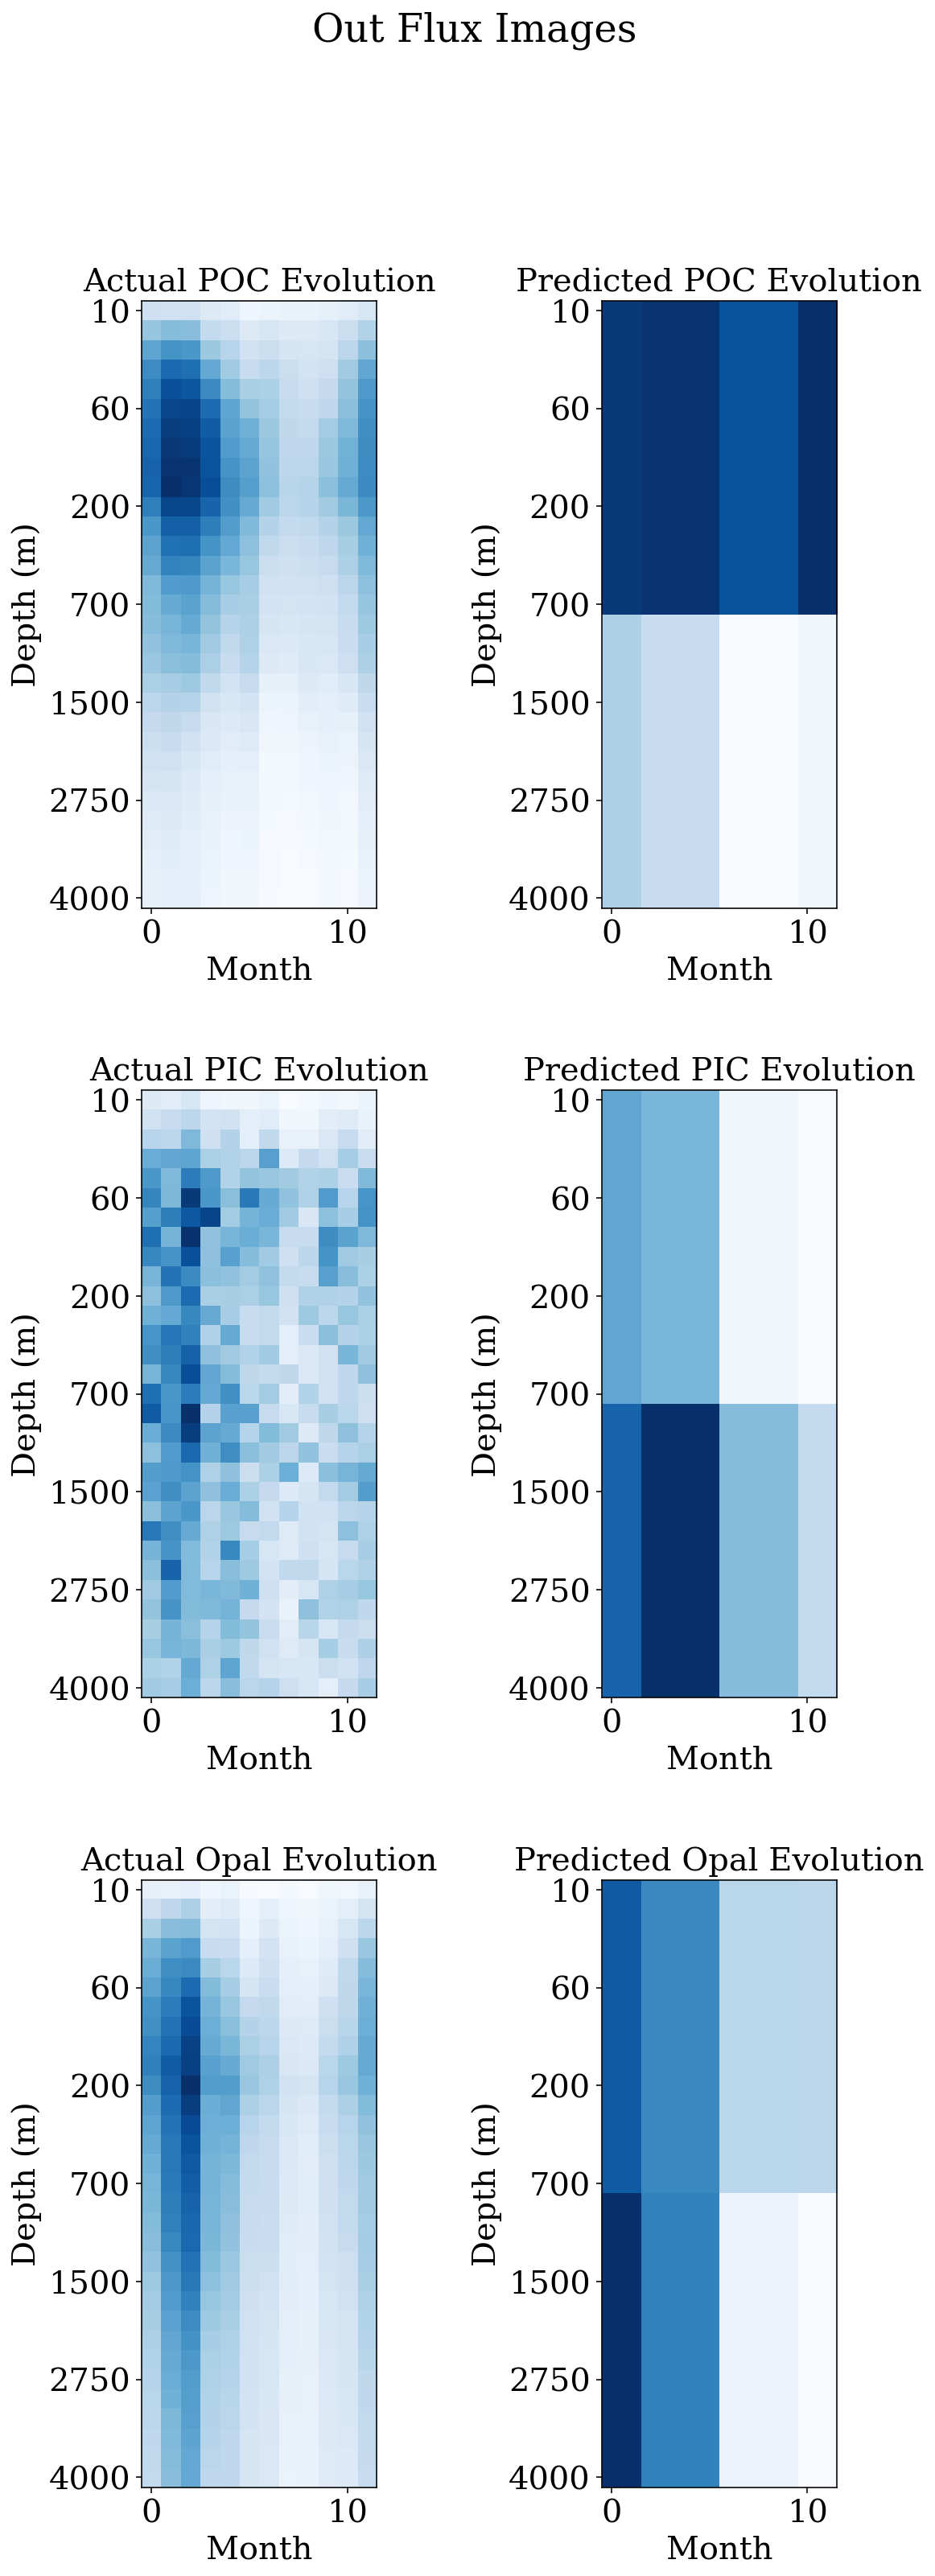

Correlations coefficients for ... 
POC evolution: 0.6892 
PIC evolution: 0.3493 
Opal evolution:0.5881

Mean and Standard Deviations for ... 
Actual POC evolution: 97.0861 +- 73.6075
Predicted POC evolution: 8.3715 +- 2.358
Actual PIC evolution: 22.31 +- 10.4497
Predicted PIC evolution: 13.1056 +- 1.487
Actual Opal evolution: 238.3296 +- 143.2209
Predicted Opal evolution: 24.4944 +- 6.3791

Min and Max for ... 
Actual POC evolution: 8.3264 , 307.5718
Predicted POC evolution: 5.2045 , 10.917

Actual PIC evolution: 1.7924 , 56.9179
Predicted PIC evolution: 11.0908 , 15.5919

Actual Opal evolution: 23.7127 , 701.2911
Predicted Opal evolution: 15.3206 , 35.3618


In [4]:
# set up the input parameters with emulator 
sample_indices = 1050
inp = torch.tensor([list(input_parameter_sets_stable[sample_indices])]) # (nbatch=1, nparams)
norm_inp = (inp - diag.lbounds) / (diag.ubounds - diag.lbounds)
print("Normalised input parameters for sample number {}: \n{}".format(sample_indices,norm_inp))

# calling the model with input sample
model_out, _ = model(norm_inp) # (nbatch, nchannel=3, 31, 12)
print(model_out.shape)
predicted_profile = diag.out_model_to_display(model_out) # (nbatch, 3,31, 12)
actual_profile = stable_out_flux_data[sample_indices]
#print(actual_profile.shape)

#plotting the outputs 
print("\nInput Parameters: \n{}: {}\n{}: {}"
      " \n{}: {}\n{}:{}"
      " \n{}: {}\n{}:{}"
      " \n{}: {}\n{}:{}"
      " \n{}: {}\n{}:{}"
      " \n{}: {}\n{}:{}"
      " \n{}: {}\n{}:{}".format(diag.varnames[0],round(np.array(inp[0][0]),4),
                                diag.varnames[1],round(np.array(inp[0][1]),4),
                                diag.varnames[2],round(np.array(inp[0][2]),4),
                                diag.varnames[3],round(np.array(inp[0][3]),4),
                                diag.varnames[4],round(np.array(inp[0][4]),4),
                                diag.varnames[5],round(np.array(inp[0][5]),4),
                                diag.varnames[6],round(np.array(inp[0][6]),4),
                                diag.varnames[7],round(np.array(inp[0][7]),4),
                                diag.varnames[8],round(np.array(inp[0][8]),4),
                                diag.varnames[9],round(np.array(inp[0][9]),4),
                                diag.varnames[10],round(np.array(inp[0][10]),4),
                                diag.varnames[11],round(np.array(inp[0][11]),10),
                                diag.varnames[12],round(np.array(inp[0][12]),4),
                                diag.varnames[13],round(np.array(inp[0][13]),4)))
#setting the plotting parameters
params = {
    'image.cmap': 'Blues',
    'axes.labelsize': 20, # fontsize for x and y labels (was 10)
    'axes.titlesize': 20,
    'font.size': 20, # was 10
    'legend.fontsize': 20, # was 10
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'figure.figsize': [10, 25],
    'font.family': 'serif',
}

#updating parameters for plotting
matplotlib.rcParams.update(params)

#setting up the graph structure
fig = plt.figure()
fig.suptitle("Out Flux Images") 
gs = matplotlib.gridspec.GridSpec(3, 2, width_ratios=[1.,1.], height_ratios=[1.,1.,1.])
gs.update(wspace=0.05, hspace=0.30)

#plotting the annual particle size distribution 
ax1 = fig.add_subplot(gs[0])
ax1.imshow(actual_profile[0],cmap ='Blues')
#ax1.set_yticks(depth_labeling[:31])
ax1.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel('Month')
ax1.set_title('Actual POC Evolution')

ax2 = fig.add_subplot(gs[1])
ax2.imshow(predicted_profile[0,0,:,:],cmap ='Blues')
#ax1.set_yticks(depth_labeling[:31])
ax2.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax2.set_ylabel('Depth (m)')
ax2.set_xlabel('Month')
ax2.set_title('Predicted POC Evolution')

ax3 = fig.add_subplot(gs[2])
ax3.imshow(actual_profile[1],cmap = 'Blues')
ax3.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax3.set_ylabel('Depth (m)')
ax3.set_xlabel('Month')
ax3.set_title('Actual PIC Evolution')

ax4 = fig.add_subplot(gs[3])
ax4.imshow(predicted_profile[0,1,:,:],cmap = 'Blues')
ax4.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax4.set_ylabel('Depth (m)')
ax4.set_xlabel('Month')
ax4.set_title('Predicted PIC Evolution')

ax5 = fig.add_subplot(gs[4])
ax5.imshow(actual_profile[2], cmap='Blues')
ax5.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax5.set_ylabel('Depth (m)')
ax5.set_xlabel('Month')
ax5.set_title('Actual Opal Evolution')

ax6 = fig.add_subplot(gs[5])
ax6.imshow(predicted_profile[0,2,:,:], cmap='Blues')
ax6.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax6.set_ylabel('Depth (m)')
ax6.set_xlabel('Month')
ax6.set_title('Predicted Opal Evolution')
plt.savefig(model_file_name + "model_outputs_for" + str(sample_indices) + "sample.png")

plt.show()

print("Correlations coefficients for ... \nPOC evolution: {} \nPIC evolution: {} \nOpal evolution:{}".format(
round(np.corrcoef(np.array(predicted_profile[0,0,:,:]).reshape(31*12),actual_profile[0].reshape(31*12))[0][1],4),
round(np.corrcoef(np.array(predicted_profile[0,1,:,:]).reshape(31*12),actual_profile[1].reshape(31*12))[0][1],4),
round(np.corrcoef(np.array(predicted_profile[0,2,:,:]).reshape(31*12),actual_profile[2].reshape(31*12))[0][1],4)))

print("\nMean and Standard Deviations for ... \nActual POC evolution: {} +- {}"
      "\nPredicted POC evolution: {} +- {}"
      "\nActual PIC evolution: {} +- {}"
      "\nPredicted PIC evolution: {} +- {}"
      "\nActual Opal evolution: {} +- {}"
      "\nPredicted Opal evolution: {} +- {}".format(
          round(np.mean(actual_profile[0].reshape(31*12)),4),round(np.std(actual_profile[0].reshape(31*12)),4),
          
          round(np.mean(np.array(predicted_profile[0,0,:,:]).reshape(31*12)),4),
          round(np.std(np.array(predicted_profile[0,0,:,:]).reshape(31*12)),4),
          
          round(np.mean(actual_profile[1].reshape(31*12)),4),round(np.std(actual_profile[1].reshape(31*12)),4),
          
          round(np.mean(np.array(predicted_profile[0,1,:,:]).reshape(31*12)),4),
          round(np.std(np.array(predicted_profile[0,1,:,:]).reshape(31*12)),4),
          
          round(np.mean(actual_profile[2].reshape(31*12)),4),round(np.std(actual_profile[2].reshape(31*12)),4),
          
          round(np.mean(np.array(predicted_profile[0,2,:,:]).reshape(31*12)),4),
          round(np.std(np.array(predicted_profile[0,2,:,:]).reshape(31*12)),4)))


print("\nMin and Max for ... \nActual POC evolution: {} , {}"
      "\nPredicted POC evolution: {} , {}"
      "\n\nActual PIC evolution: {} , {}"
      "\nPredicted PIC evolution: {} , {}"
      "\n\nActual Opal evolution: {} , {}"
      "\nPredicted Opal evolution: {} , {}".format(
          round(np.min(actual_profile[0].reshape(31*12)),4),round(np.max(actual_profile[0].reshape(31*12)),4),
          round(np.min(np.array(predicted_profile[0,0,:,:]).reshape(31*12)),4),
          round(np.max(np.array(predicted_profile[0,0,:,:]).reshape(31*12)),4),
          round(np.min(actual_profile[1].reshape(31*12)),4),round(np.max(actual_profile[1].reshape(31*12)),4),
          round(np.min(np.array(predicted_profile[0,1,:,:]).reshape(31*12)),4),
          round(np.max(np.array(predicted_profile[0,1,:,:]).reshape(31*12)),4),
          round(np.min(actual_profile[2].reshape(31*12)),4),round(np.max(actual_profile[2].reshape(31*12)),4),
          round(np.min(np.array(predicted_profile[0,2,:,:]).reshape(31*12)),4),
          round(np.max(np.array(predicted_profile[0,2,:,:]).reshape(31*12)),4)))



### Emulator Performance

As we can see the emulator training performs very poorly on this data. It could either be due to a low Signal-to-Noise ratio (SNR) in the data (very noisy relation) or there is no signal at all (i.e. no relation between the input samples and the output samples). Arguably adding extra information (e.g. more outputs) might improve the learning of the deep emulator Neural Network. For now we want to attempt to get better prediction using other ML algorithms (see next section).

## With Other ML algorithms

Run these cells to load other **trained** ML model a.k.a the regressors. You need to check the loss functions to see which regressors performed the best (i.e. the lowest loss value in *results_huber.txt* at the end of training). After you run the *otherml.py* file you have the choice out of the following regressors:
 - GaussianProcessRegressor
 - LinearSVR
 - NuSVR
 - SVR
 - AdaBoostRegressor
 - GradientBoostingRegressor
 - ExtraTreesRegressor
 - RandomForestRegressor
 - BaggingRegressor
 
Make sure to download the wieghts (i.e. pkl file) of the model with the lowest huber loss value into ***your_working_directory**/results-oml/trained-objects/* path. It will usually be named *slams2_outflux-**your_regressor ***  where **your_regressor** is the name of your chosen regressor from the list above. Please insert that name into the `weights` variable below. The rest of the cell loads the model and predictions. **NOTE:** do not attempt to downlod all pkl files in the *results-oml/trained-objects/* directory as every weight file for every model can be quite heavy (up to several Gb!!!).
 
In the next cell choose which subset you want to predict. This model samples work slightly differenty. Here the datasets are loaded directly from the .bin files with data. **That means if the dataset used for training is replicated (i.e. `self.nmult =! 1` in *Codes/deepemu2/deepemulator/diags/slams2_outflux.py* )** then the train, validation and test subsets will have repeated entries in them. This needs to be tidied up befpre the model prediction can be compared to the acual data for performance analysis.

 

In [3]:
%%time
# load the diagnostic/simulation details and the model
otherml_name = "ExtraTreesRegressor"
model_file_name = "results-oml/trained-objects/"
weights = "slams2-ExtraTreesRegressor.pkl"

diag = getdiagnostic("slams2_outflux")

#loading the datasets
#train_dataset = ForwardDataset(diag, "train")
#val_dataset = ForwardDataset(diag, "val")
#test_dataset = ForwardDataset(diag, "test")

# collect all the datasets
#Xtrain, ytrain = train_dataset.getall(numpy=True)
#Xval, yval = val_dataset.getall(numpy=True)
#Xtest, ytest = test_dataset.getall(numpy=True)

# reshaping to get the proper output
#ytrain = np.reshape(ytrain, (ytrain.shape[0], -1))
#yval   = np.reshape(yval  , (yval.shape[0]  , -1))
#ytest  = np.reshape(ytest , (ytest.shape[0] , -1))

with open(model_file_name + weights, "rb") as fb:
    reg = pickle.load(fb)

/media/vic97/LENOVO/Oxford_placement_2020/Machine_Learning/Codes/Py27/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


CPU times: user 30 s, sys: 9.07 s, total: 39.1 s
Wall time: 1min


In [5]:
test_dataset = ForwardDataset(diag, "test")
Xtest, ytest = test_dataset.getall(numpy=True)
ytest  = np.reshape(ytest , (ytest.shape[0] , -1))


In [22]:
Xtest

array([[1.968e+00, 2.675e-01, 6.913e-01, ..., 1.804e-06, 1.783e+02,
        2.802e+01],
       [1.968e+00, 2.675e-01, 6.913e-01, ..., 1.804e-06, 1.783e+02,
        2.802e+01],
       [2.108e+00, 2.761e-01, 6.487e-01, ..., 2.840e-07, 9.611e+01,
        2.989e+01],
       ...,
       [2.212e+00, 5.398e-01, 1.427e+00, ..., 8.730e-07, 1.729e+02,
        4.954e+00],
       [2.212e+00, 5.398e-01, 1.427e+00, ..., 8.730e-07, 1.729e+02,
        4.954e+00],
       [2.212e+00, 5.398e-01, 1.427e+00, ..., 8.730e-07, 1.729e+02,
        4.954e+00]], dtype=float32)

In [7]:
trial_inp = np.array([2,0.3,0.7,0.25,0.9,0.6,6,0.7,0.113,0.45,5.3,1.4e-6,175,26]).reshape(1,-1)

prof = np.array(diag.out_model_to_display(torch.Tensor(reg.predict(trial_inp)))).reshape(3,31,12)

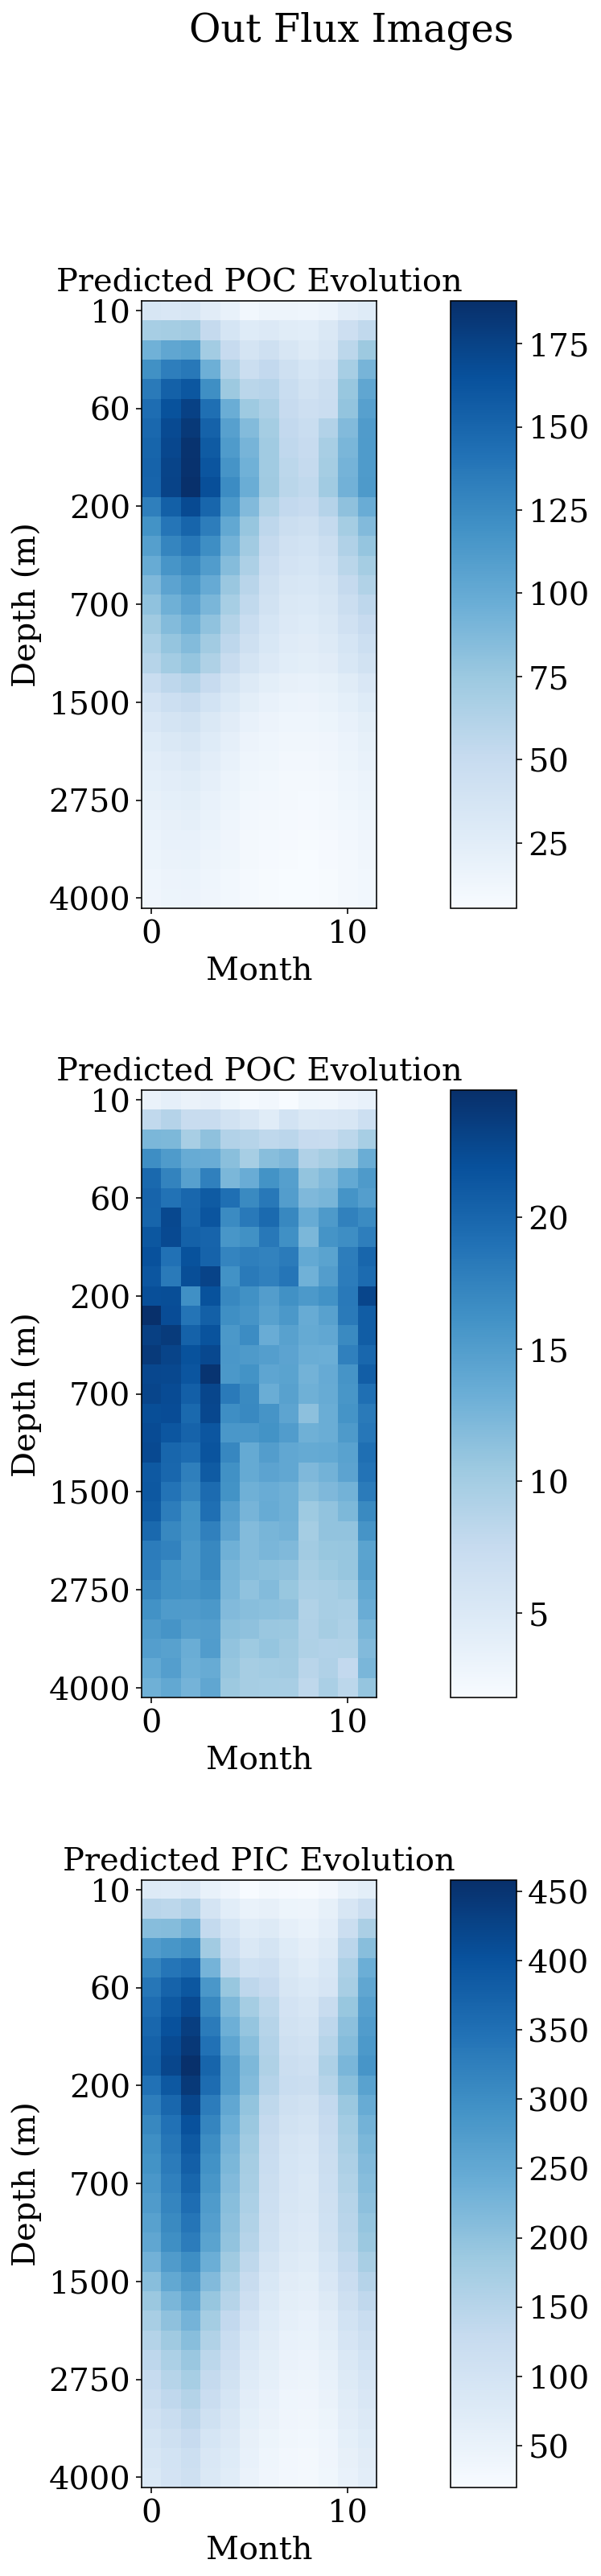

In [8]:
#setting the plotting parameters
params = {
    'image.cmap': 'Blues',
    'axes.labelsize': 20, # fontsize for x and y labels (was 10)
    'axes.titlesize': 20,
    'font.size': 20, # was 10
    'legend.fontsize': 20, # was 10
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'figure.figsize': [5, 25],
    'font.family': 'serif',
}

#updating parameters for plotting
matplotlib.rcParams.update(params)

#setting up the graph structure
fig = plt.figure()
fig.suptitle("Out Flux Images") 
gs = matplotlib.gridspec.GridSpec(3, 2, width_ratios=[1.,.8], height_ratios=[1.,1.,1.])
gs.update(wspace=0.0001, hspace=0.30)

#plotting the annual particle size distribution 
ax1 = fig.add_subplot(gs[0])
ax1.set_aspect(1.0)
im1 = ax1.imshow(prof[0],cmap ='Blues')
ax1.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel('Month')
ax1.set_title('Predicted POC Evolution')

cax1 = fig.add_subplot(gs[1])
cax1.set_aspect(9.2)
cbar1=fig.colorbar(im1,cax=cax1)

ax2 = fig.add_subplot(gs[2])
ax2.set_aspect(1.0)
im2 = ax2.imshow(prof[1],cmap ='Blues')
ax2.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax2.set_ylabel('Depth (m)')
ax2.set_xlabel('Month')
ax2.set_title('Predicted POC Evolution')

cax2 = fig.add_subplot(gs[3])
cax2.set_aspect(9.2)
cbar2=fig.colorbar(im2,cax=cax2)

ax3 = fig.add_subplot(gs[4])
ax3.set_aspect(1.0)
im3 = ax3.imshow(prof[2],cmap = 'Blues')
ax3.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax3.set_ylabel('Depth (m)')
ax3.set_xlabel('Month')
ax3.set_title('Predicted PIC Evolution')

cax3 = fig.add_subplot(gs[5])
cax3.set_aspect(9.2)
cbar3=fig.colorbar(im3,cax=cax3)

#plt.savefig(otherml_name + "_outputs_for" + str(sample_index) + "sample.png")

plt.show()


In [9]:
# make a prediction
#yhat_train = reg.predict(Xtrain)
#yhat_val = reg.predict(Xval)
yhat_test = reg.predict(Xtest)

# get the error
#train_err = crit(yhat_train, ytrain)
#val_err = crit(yhat_val, yval)
test_err = huber(yhat_test, ytest)

In [10]:
#droping duplicated samples
unique_yhat_test = pd.DataFrame(yhat_test).drop_duplicates().iloc[1:].reset_index(drop=True)
unique_ytest = pd.DataFrame(ytest).drop_duplicates().iloc[1:].reset_index(drop=True)

Normalised input parameters for sample number 1050: 
tensor([[0.9630, 0.9616, 0.0870, 0.8317, 0.5623, 0.1817, 0.9270, 0.5004, 0.5150,
         0.2896, 0.1397, 0.5176, 0.7015, 0.3955]])
84

Input Parameters: 
fractal_dimension_agg: 2.263
Si2C_diat: 0.6262 
Calc2C_cocco: 0.674
k_NO3_diat:2.512 
k_NO3_cocco: 0.6061
phyto_exudation_frac:0.1254 
poc_to_zoo: 9.416
poc_to_zoo_night_dvmdepth:0.6003 
resp_rate_max_mesozoo: 0.1433
resp_rate_max_bact:0.1519 
dissol_timescale_calc: 1.838
NPP:2.08e-06 
SiOH4: 126.3
Temperature:12.47


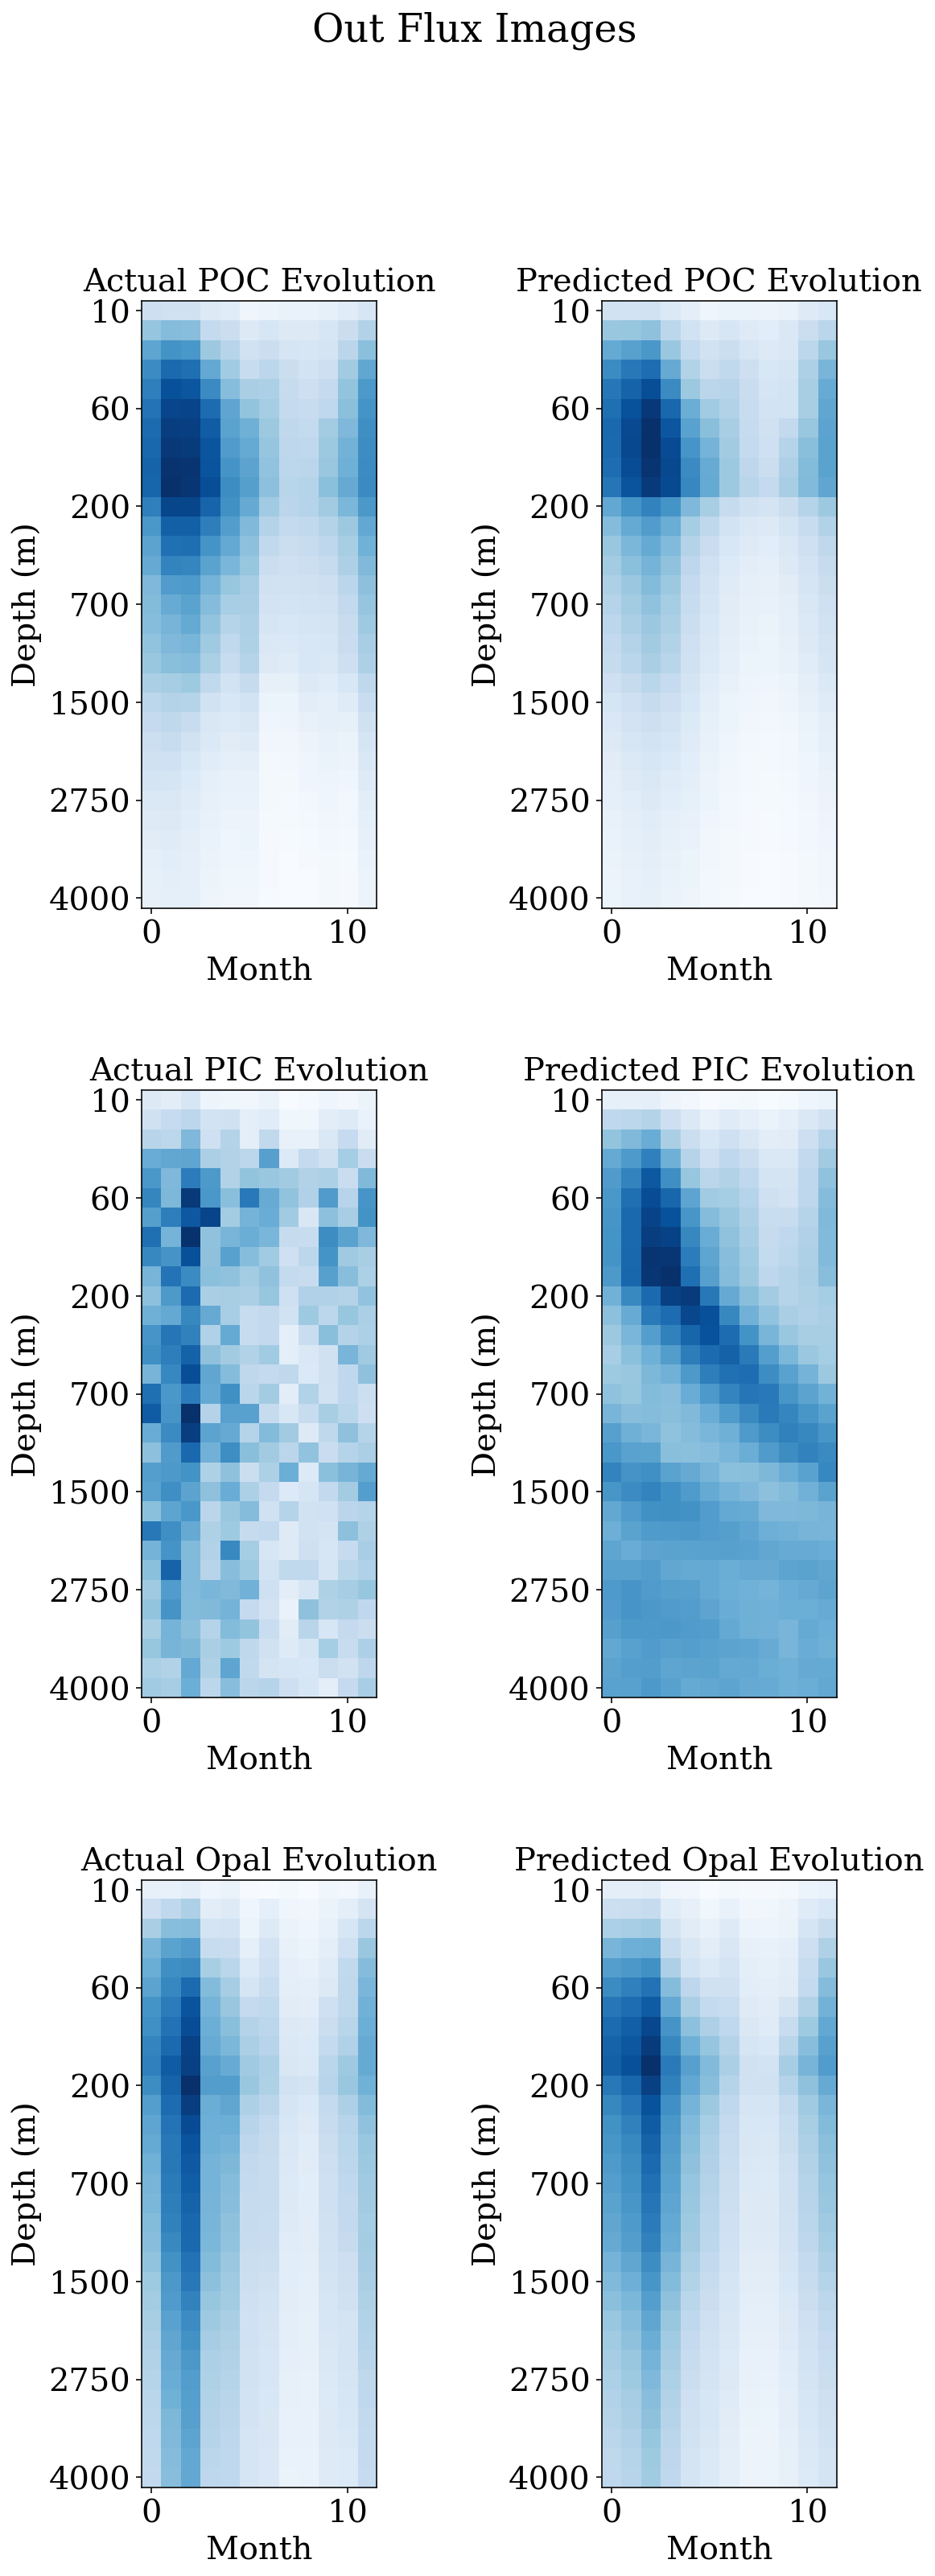

Correlations coefficients for ... 
POC evolution: 0.9623 
PIC evolution: 0.3973 
Opal evolution:0.9652

Mean and Standard Deviations for ... 
Actual POC evolution: 97.0861 +- 73.6075
Predicted POC evolution: 10.8805 +- 9.3953
Actual PIC evolution: 22.31 +- 10.4497
Predicted PIC evolution: 114.191 +- 38.4189
Actual Opal evolution: 238.3296 +- 143.2209
Predicted Opal evolution: 9.575 +- 6.0619

Min and Max for ... 
Actual POC evolution: 8.3264 , 307.5718
Predicted POC evolution: 1.0542 , 42.2408

Actual PIC evolution: 1.7924 , 56.9179
Predicted PIC evolution: 12.5526 , 219.0099

Actual Opal evolution: 23.7127 , 701.2911
Predicted Opal evolution: 0.727 , 29.3098


In [13]:
# set up the input parameters with emulator 
sample_index = 1050
inp = torch.tensor([list(input_parameter_sets_stable[sample_index])]) # (nbatch=1, nparams)
norm_inp = (inp - diag.lbounds) / (diag.ubounds - diag.lbounds)
print("Normalised input parameters for sample number {}: \n{}".format(sample_index,norm_inp))

#convert the sample index to the sample index for the test subset
test_sample_index = sample_index - (1286 - len(unique_yhat_test))-1
print(test_sample_index)

# output of the model with the chosen input sample
other_model_out = torch.Tensor(np.array(unique_yhat_test.iloc[test_sample_index]).reshape(1,3,31,12))
predicted_profile = diag.out_model_to_display(other_model_out)
actual_profile = stable_out_flux_data[sample_index]
#print(actual_profile.shape)

#plotting the outputs 
print("\nInput Parameters: \n{}: {}\n{}: {}"
      " \n{}: {}\n{}:{}"
      " \n{}: {}\n{}:{}"
      " \n{}: {}\n{}:{}"
      " \n{}: {}\n{}:{}"
      " \n{}: {}\n{}:{}"
      " \n{}: {}\n{}:{}".format(diag.varnames[0],round(np.array(inp[0][0]),4),
                                diag.varnames[1],round(np.array(inp[0][1]),4),
                                diag.varnames[2],round(np.array(inp[0][2]),4),
                                diag.varnames[3],round(np.array(inp[0][3]),4),
                                diag.varnames[4],round(np.array(inp[0][4]),4),
                                diag.varnames[5],round(np.array(inp[0][5]),4),
                                diag.varnames[6],round(np.array(inp[0][6]),4),
                                diag.varnames[7],round(np.array(inp[0][7]),4),
                                diag.varnames[8],round(np.array(inp[0][8]),4),
                                diag.varnames[9],round(np.array(inp[0][9]),4),
                                diag.varnames[10],round(np.array(inp[0][10]),4),
                                diag.varnames[11],round(np.array(inp[0][11]),10),
                                diag.varnames[12],round(np.array(inp[0][12]),4),
                                diag.varnames[13],round(np.array(inp[0][13]),4)))
#setting the plotting parameters
params = {
    'image.cmap': 'Blues',
    'axes.labelsize': 20, # fontsize for x and y labels (was 10)
    'axes.titlesize': 20,
    'font.size': 20, # was 10
    'legend.fontsize': 20, # was 10
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'figure.figsize': [10, 25],
    'font.family': 'serif',
}

#updating parameters for plotting
matplotlib.rcParams.update(params)

#setting up the graph structure
fig = plt.figure()
fig.suptitle("Out Flux Images") 
gs = matplotlib.gridspec.GridSpec(3, 2, width_ratios=[1.,1.], height_ratios=[1.,1.,1.])
gs.update(wspace=0.05, hspace=0.30)

#plotting the annual particle size distribution 
ax1 = fig.add_subplot(gs[0])
ax1.imshow(actual_profile[0],cmap ='Blues')
#ax1.set_yticks(depth_labeling[:31])
ax1.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel('Month')
ax1.set_title('Actual POC Evolution')

ax2 = fig.add_subplot(gs[1])
ax2.imshow(predicted_profile[0,0,:,:],cmap ='Blues')
#ax1.set_yticks(depth_labeling[:31])
ax2.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax2.set_ylabel('Depth (m)')
ax2.set_xlabel('Month')
ax2.set_title('Predicted POC Evolution')

ax3 = fig.add_subplot(gs[2])
ax3.imshow(actual_profile[1],cmap = 'Blues')
ax3.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax3.set_ylabel('Depth (m)')
ax3.set_xlabel('Month')
ax3.set_title('Actual PIC Evolution')

ax4 = fig.add_subplot(gs[3])
ax4.imshow(predicted_profile[0,1,:,:],cmap = 'Blues')
ax4.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax4.set_ylabel('Depth (m)')
ax4.set_xlabel('Month')
ax4.set_title('Predicted PIC Evolution')

ax5 = fig.add_subplot(gs[4])
ax5.imshow(actual_profile[2], cmap='Blues')
ax5.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax5.set_ylabel('Depth (m)')
ax5.set_xlabel('Month')
ax5.set_title('Actual Opal Evolution')

ax6 = fig.add_subplot(gs[5])
ax6.imshow(predicted_profile[0,2,:,:], cmap='Blues')
ax6.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax6.set_ylabel('Depth (m)')
ax6.set_xlabel('Month')
ax6.set_title('Predicted Opal Evolution')
plt.savefig(otherml_name + "_outputs_for" + str(sample_index) + "sample.png")

plt.show()

print("Correlations coefficients for ... \nPOC evolution: {} \nPIC evolution: {} \nOpal evolution:{}".format(
round(np.corrcoef(np.array(predicted_profile[0,0,:,:]).reshape(31*12),actual_profile[0].reshape(31*12))[0][1],4),
round(np.corrcoef(np.array(predicted_profile[0,1,:,:]).reshape(31*12),actual_profile[1].reshape(31*12))[0][1],4),
round(np.corrcoef(np.array(predicted_profile[0,2,:,:]).reshape(31*12),actual_profile[2].reshape(31*12))[0][1],4)))

print("\nMean and Standard Deviations for ... \nActual POC evolution: {} +- {}"
      "\nPredicted POC evolution: {} +- {}"
      "\nActual PIC evolution: {} +- {}"
      "\nPredicted PIC evolution: {} +- {}"
      "\nActual Opal evolution: {} +- {}"
      "\nPredicted Opal evolution: {} +- {}".format(
          round(np.mean(actual_profile[0].reshape(31*12)),4),round(np.std(actual_profile[0].reshape(31*12)),4),
          
          round(np.mean(np.array(predicted_profile[0,0,:,:]).reshape(31*12)),4),
          round(np.std(np.array(predicted_profile[0,0,:,:]).reshape(31*12)),4),
          
          round(np.mean(actual_profile[1].reshape(31*12)),4),round(np.std(actual_profile[1].reshape(31*12)),4),
          
          round(np.mean(np.array(predicted_profile[0,1,:,:]).reshape(31*12)),4),
          round(np.std(np.array(predicted_profile[0,1,:,:]).reshape(31*12)),4),
          
          round(np.mean(actual_profile[2].reshape(31*12)),4),round(np.std(actual_profile[2].reshape(31*12)),4),
          
          round(np.mean(np.array(predicted_profile[0,2,:,:]).reshape(31*12)),4),
          round(np.std(np.array(predicted_profile[0,2,:,:]).reshape(31*12)),4)))


print("\nMin and Max for ... \nActual POC evolution: {} , {}"
      "\nPredicted POC evolution: {} , {}"
      "\n\nActual PIC evolution: {} , {}"
      "\nPredicted PIC evolution: {} , {}"
      "\n\nActual Opal evolution: {} , {}"
      "\nPredicted Opal evolution: {} , {}".format(
          round(np.min(actual_profile[0].reshape(31*12)),4),round(np.max(actual_profile[0].reshape(31*12)),4),
          round(np.min(np.array(predicted_profile[0,0,:,:]).reshape(31*12)),4),
          round(np.max(np.array(predicted_profile[0,0,:,:]).reshape(31*12)),4),
          round(np.min(actual_profile[1].reshape(31*12)),4),round(np.max(actual_profile[1].reshape(31*12)),4),
          round(np.min(np.array(predicted_profile[0,1,:,:]).reshape(31*12)),4),
          round(np.max(np.array(predicted_profile[0,1,:,:]).reshape(31*12)),4),
          round(np.min(actual_profile[2].reshape(31*12)),4),round(np.max(actual_profile[2].reshape(31*12)),4),
          round(np.min(np.array(predicted_profile[0,2,:,:]).reshape(31*12)),4),
          round(np.max(np.array(predicted_profile[0,2,:,:]).reshape(31*12)),4)))



## Analysis of the emulator outputs 

We perform calculation of the test samples emulator output and save those images. We then perform correlation and other analysis to see how the model can be improved.

In [5]:
#saving the model outputs
testing_samples_prediction = []
for i in range(965,1286):    
    sample_indices = i
    inp = torch.tensor([list(input_parameter_sets_stable[sample_indices])]) # (nbatch=1, nparams)
    norm_inp = (inp - diag.lbounds) / (diag.ubounds - diag.lbounds)
    #print("Normalised input parameters for sample number {}: \n{}".format(sample_indices,norm_inp))

    # calling the model with input sample
    model_out, _ = model(norm_inp) # (nbatch, nchannel=3, 31, 12)
    #print(model_out.shape)
    predicted_profile = list(diag.out_model_to_display(model_out).numpy().reshape(3*31*12)) # (nbatch, 3,31, 12)
    testing_samples_prediction.append(predicted_profile)
  
#saving the model output
#np.savetxt("Predicted_test_samples_from_initial_model.txt",
    #np.array(testing_samples_prediction).reshape(321, 3*31*12))


/media/vic97/LENOVO/Oxford_placement_2020/Machine_Learning/Codes/Py27/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


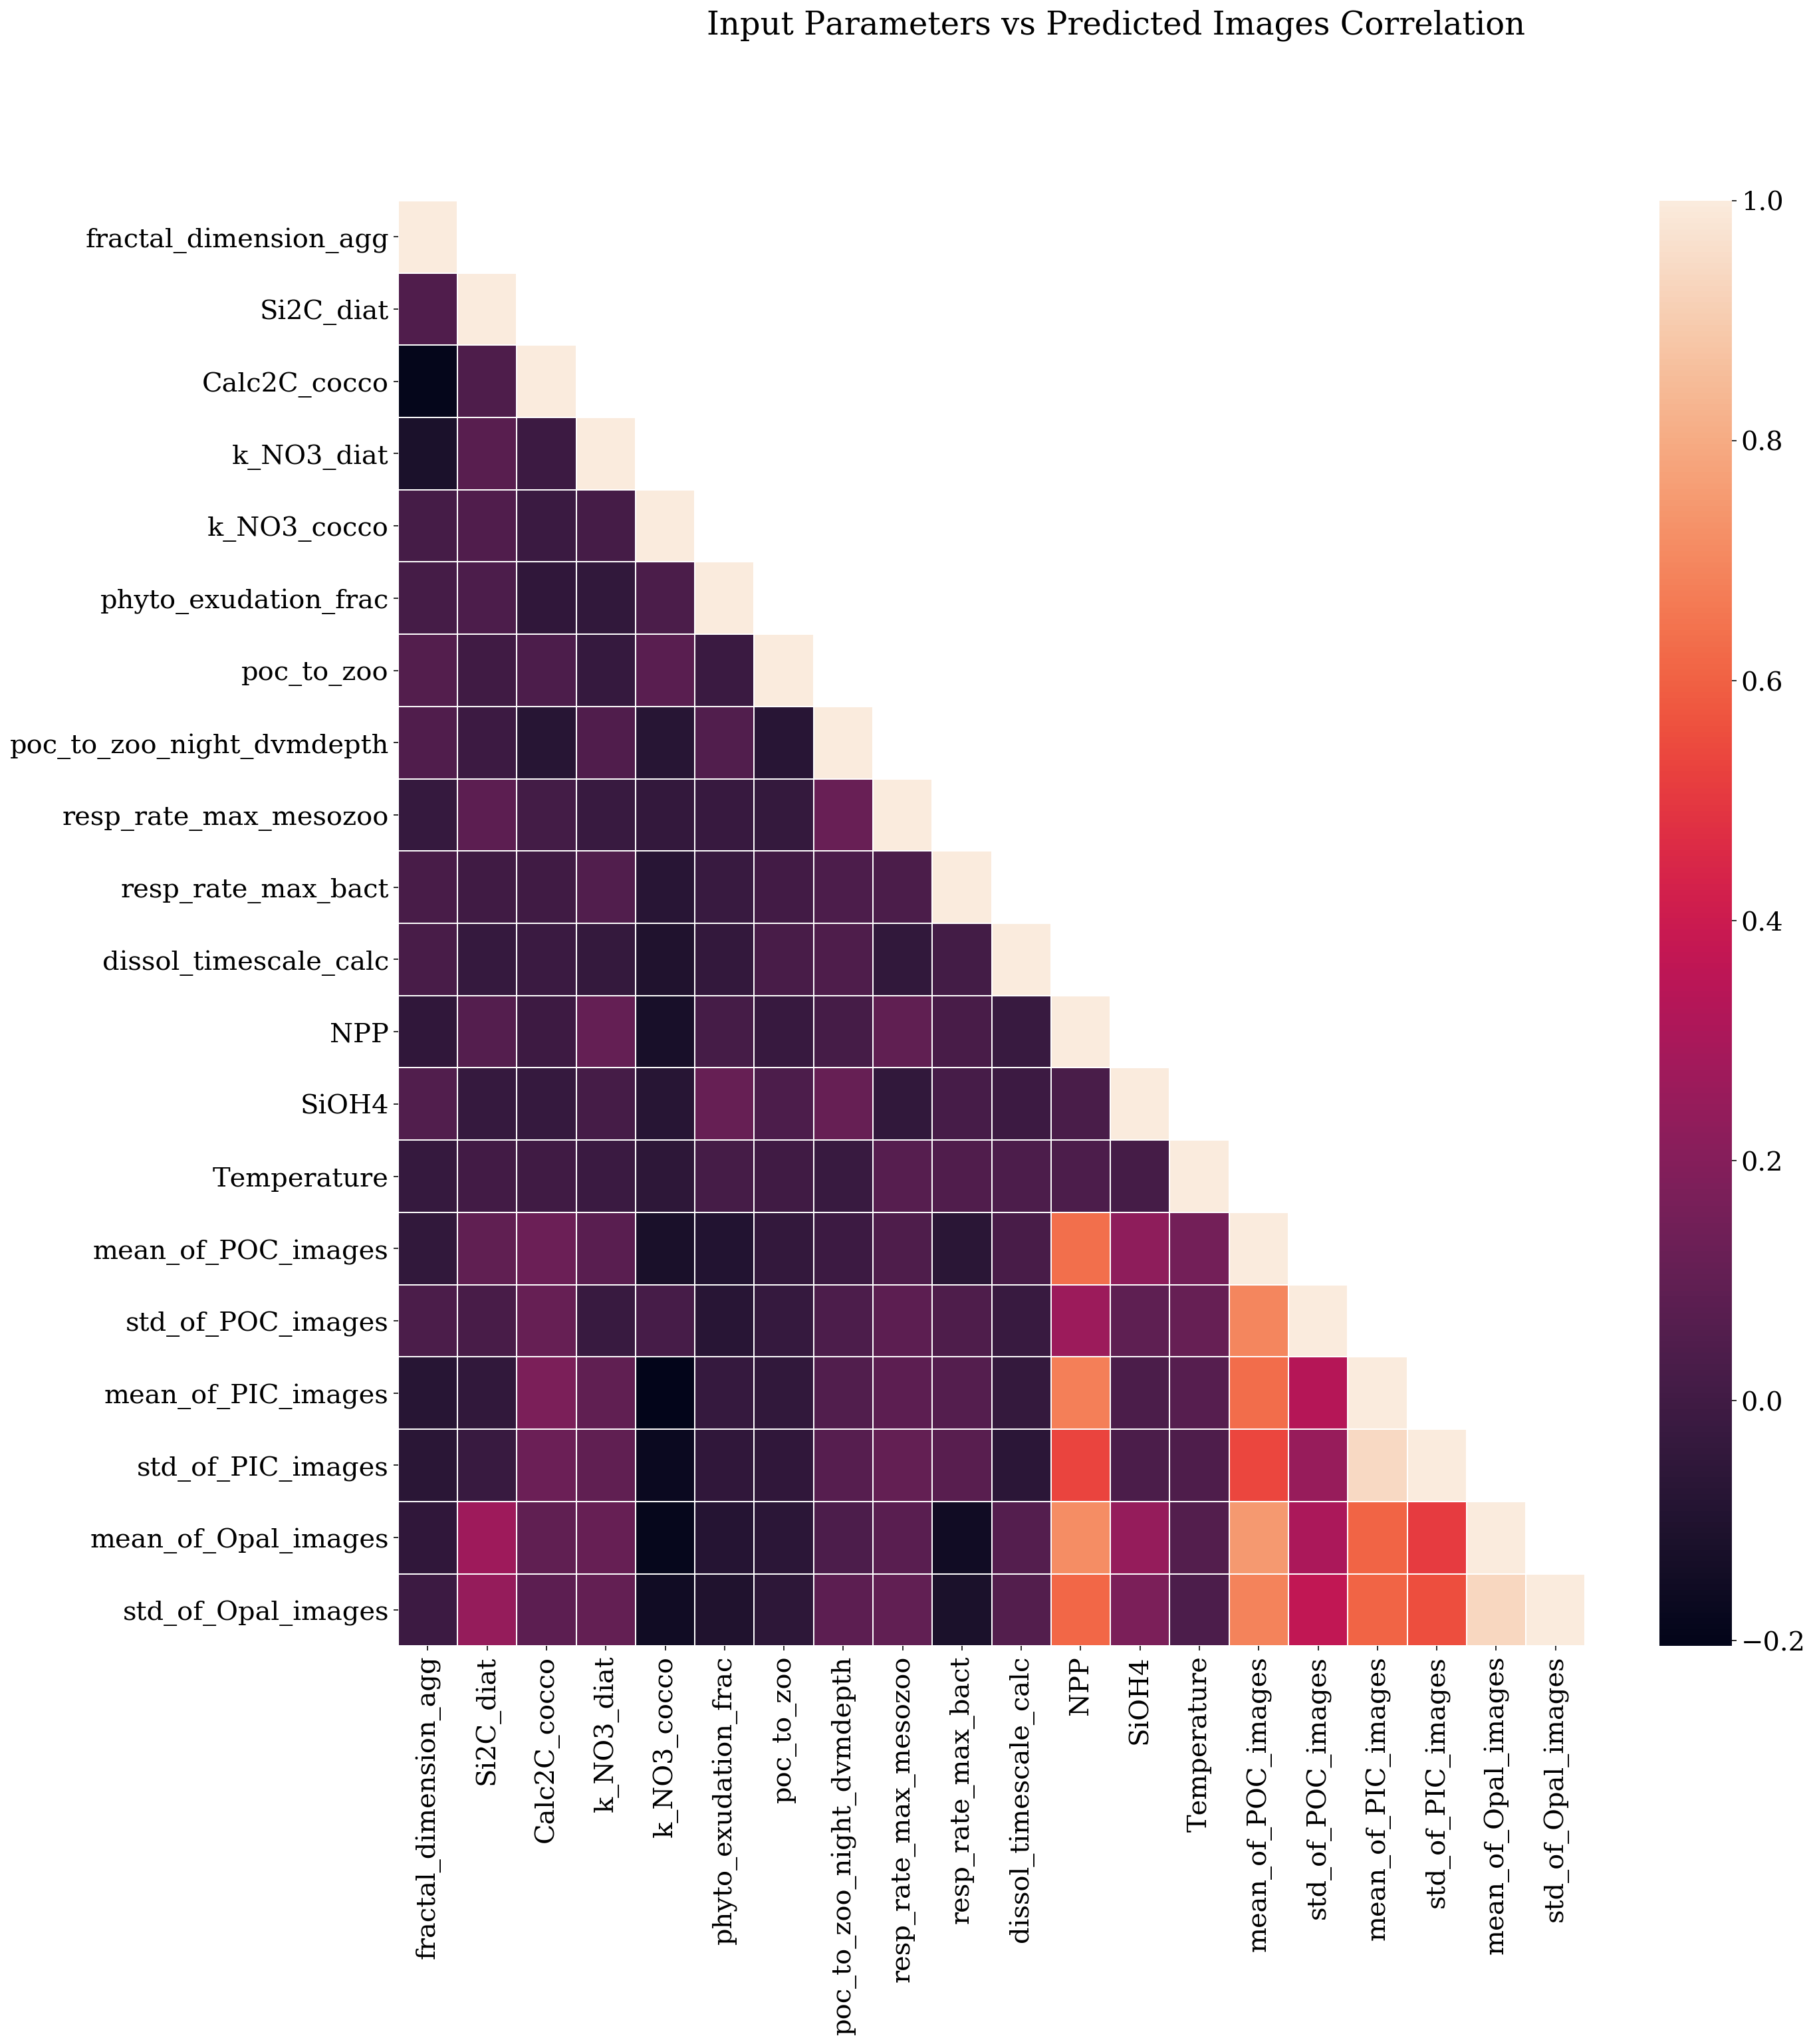

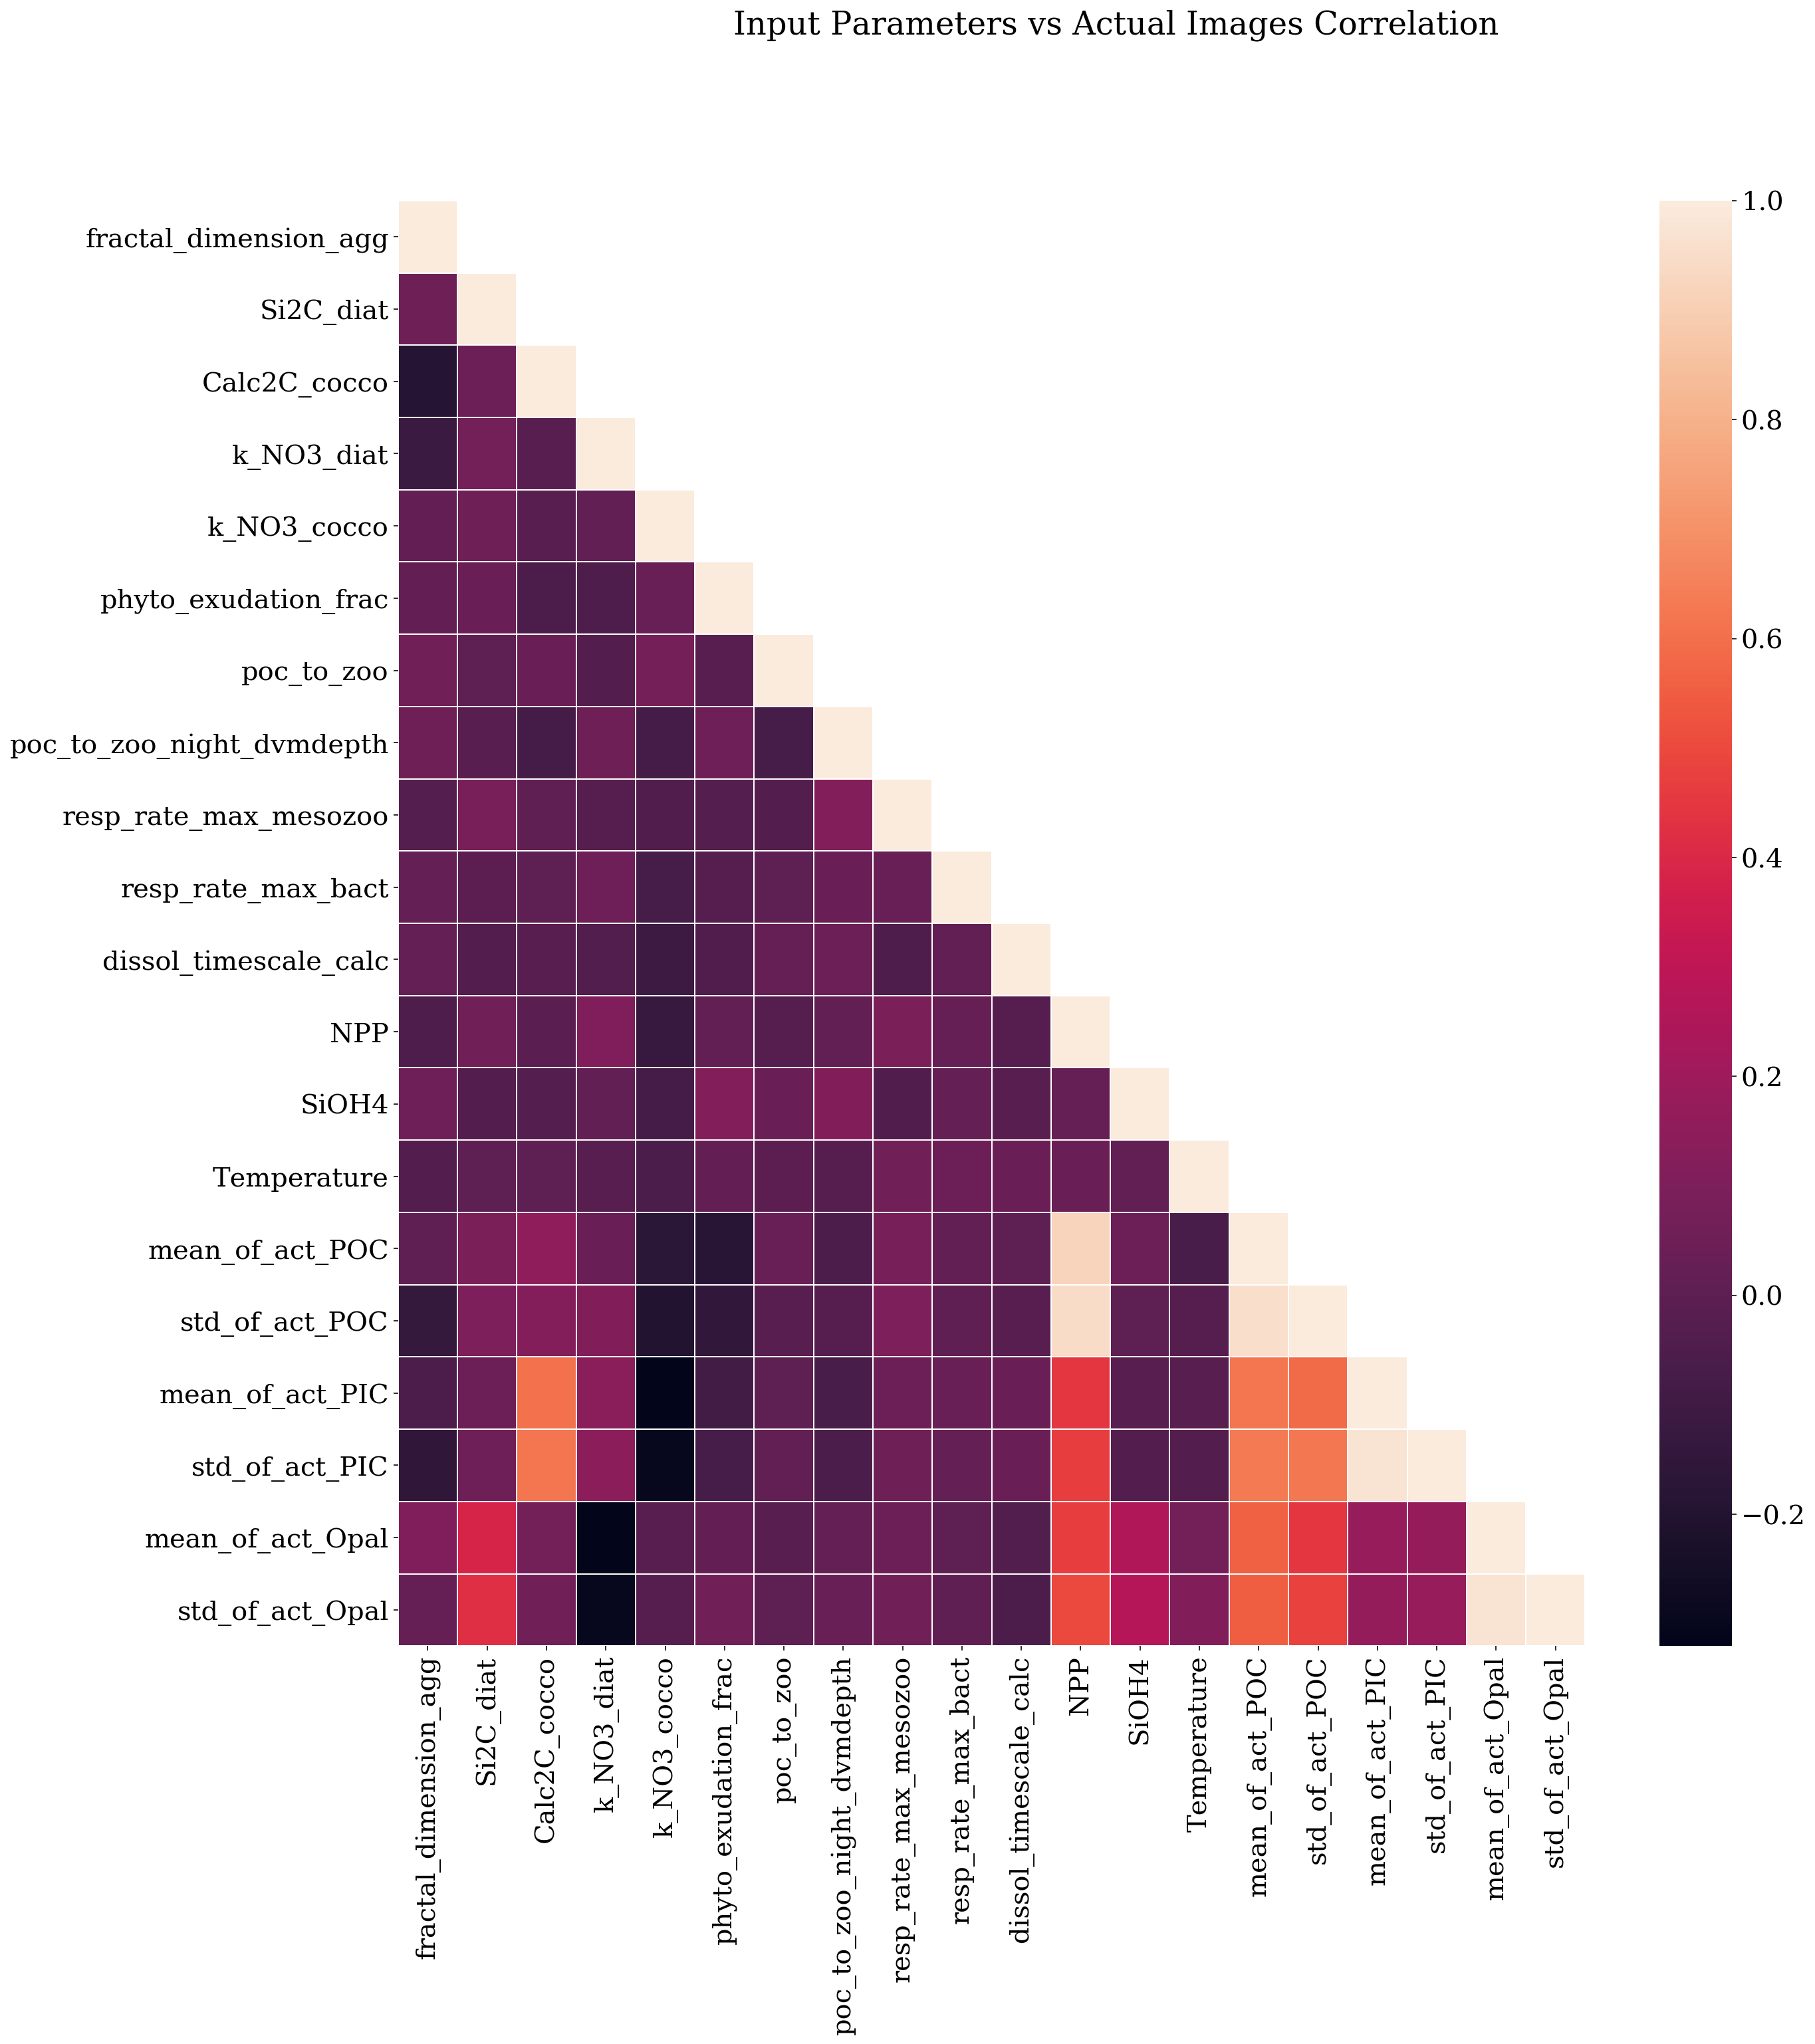

In [6]:
#rearanging the dataset for mean and std calculation of each element
predictions = np.array(testing_samples_prediction).reshape(321*3,31*12)
#element labeling
element_number = list(np.arange(3))*321

#putting prediction data in dataset format
separating_elements_pred = pd.DataFrame(predictions)
separating_elements_pred['element_code'] = element_number
separating_elements_pred['mean_of_image'] = separating_elements_pred[
    separating_elements_pred.columns[:-1]].mean(axis=1)
separating_elements_pred['std_of_image'] = separating_elements_pred[
    separating_elements_pred.columns[:-1]].std(axis=1)

#putting actual data in dataset format
separating_elements_actual = pd.DataFrame(stable_out_flux_data.reshape(1286,3*31*12)[965:].reshape(321*3,31*12))
separating_elements_actual['element_code'] = element_number
separating_elements_actual['mean_of_act_images'] = separating_elements_actual[
    separating_elements_actual.columns[:-1]].mean(axis=1)
separating_elements_actual['std_of_act_images'] = separating_elements_actual[
    separating_elements_actual.columns[:-1]].std(axis=1)

#adding predicted test data to the input paraneters data for correlation analysis 
correlations_data = pd.DataFrame(input_parameter_sets_stable[965:], columns=diag.varnames)
correlations_data['mean_of_POC_images'] = separating_elements_pred[separating_elements_pred[
    'element_code']==0]['mean_of_image'].reset_index(drop=True)
correlations_data['std_of_POC_images'] = separating_elements_pred[separating_elements_pred[
    'element_code']==0]['std_of_image'].reset_index(drop=True)
correlations_data['mean_of_PIC_images'] = separating_elements_pred[separating_elements_pred[
    'element_code']==1]['mean_of_image'].reset_index(drop=True)
correlations_data['std_of_PIC_images'] = separating_elements_pred[separating_elements_pred[
    'element_code']==1]['std_of_image'].reset_index(drop=True)
correlations_data['mean_of_Opal_images'] = separating_elements_pred[separating_elements_pred[
    'element_code']==2]['mean_of_image'].reset_index(drop=True)
correlations_data['std_of_Opal_images'] = separating_elements_pred[separating_elements_pred[
    'element_code']==2]['std_of_image'].reset_index(drop=True)
df_corr_pred_data = correlations_data.corr().where(np.tril(np.ones(correlations_data.corr().shape)).astype(np.bool))

#adding actual test data to the input paraneters data for correlation analysis 
correlations_data_act = pd.DataFrame(input_parameter_sets_stable[965:], columns=diag.varnames)
correlations_data_act['mean_of_act_POC'] = separating_elements_actual[separating_elements_actual[
    'element_code']==0]['mean_of_act_images'].reset_index(drop=True)
correlations_data_act['std_of_act_POC'] = separating_elements_actual[separating_elements_actual[
    'element_code']==0]['std_of_act_images'].reset_index(drop=True)
correlations_data_act['mean_of_act_PIC'] = separating_elements_actual[separating_elements_actual[
    'element_code']==1]['mean_of_act_images'].reset_index(drop=True)
correlations_data_act['std_of_act_PIC'] = separating_elements_actual[separating_elements_actual[
    'element_code']==1]['std_of_act_images'].reset_index(drop=True)
correlations_data_act['mean_of_act_Opal'] = separating_elements_actual[separating_elements_actual[
    'element_code']==2]['mean_of_act_images'].reset_index(drop=True)
correlations_data_act['std_of_act_Opal'] = separating_elements_actual[separating_elements_actual[
    'element_code']==2]['std_of_act_images'].reset_index(drop=True)
df_corr_act_data = correlations_data_act.corr().where(np.tril(np.ones(
    correlations_data_act.corr().shape)).astype(np.bool))


#setting the plotting parameters
params = {
    'image.cmap': 'Blues',
    'axes.labelsize': 20, # fontsize for x and y labels (was 10)
    'axes.titlesize': 20,
    'font.size': 20, # was 10
    'legend.fontsize': 20, # was 10
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'figure.figsize': [20, 20],
    'figure.autolayout': True,
    'font.family': 'serif',
}

#updating parameters for plotting
matplotlib.rcParams.update(params)

#plotting the correlation matrix
fig = plt.figure()
fig.suptitle("Input Parameters vs Predicted Images Correlation") 
gs = matplotlib.gridspec.GridSpec(1, 1, width_ratios=[1.], height_ratios=[1.])
gs.update(wspace=0.05, hspace=0.05)

#plotting the annual particle size distribution 
ax1 = fig.add_subplot(gs[0])
sns.heatmap(df_corr_pred_data, linewidths=.5, ax=ax1)
plt.savefig( model_file_name + "correlations_pred.png", bbox_inches='tight')
plt.show()


#plotting the correlation matrix
fig = plt.figure()
fig.suptitle("Input Parameters vs Actual Images Correlation") 
gs = matplotlib.gridspec.GridSpec(1, 1, width_ratios=[1.], height_ratios=[1.])
gs.update(wspace=0.05, hspace=0.05)

#plotting the annual particle size distribution 
ax1 = fig.add_subplot(gs[0])
sns.heatmap(df_corr_act_data, linewidths=.5, ax=ax1)
plt.savefig(model_file_name + "correlations_act.png", bbox_inches='tight')
plt.show()



In [7]:
ordered_corr_act_data = pd.DataFrame(df_corr_act_data.unstack().dropna().sort_values(ascending=False), columns=['corr_coeff']).drop_duplicates()
ordered_corr_act_data[1:20]

corr_coeff
mean_of_act_PIC  std_of_act_PIC      0.973779
mean_of_act_Opal std_of_act_Opal     0.970693
mean_of_act_POC  std_of_act_POC      0.956029
NPP              std_of_act_POC      0.943912
                 mean_of_act_POC     0.918352
mean_of_act_POC  std_of_act_PIC      0.631745
std_of_act_POC   std_of_act_PIC      0.624594
mean_of_act_POC  mean_of_act_PIC     0.622629
Calc2C_cocco     std_of_act_PIC      0.618414
                 mean_of_act_PIC     0.604155
std_of_act_POC   mean_of_act_PIC     0.587714
mean_of_act_POC  mean_of_act_Opal    0.561579
                 std_of_act_Opal     0.554664
NPP              std_of_act_Opal     0.498265
std_of_act_POC   std_of_act_Opal     0.482803
NPP              mean_of_act_Opal    0.468191
                 std_of_act_PIC      0.465106
                 mean_of_act_PIC     0.448034
std_of_act_POC   mean_of_act_Opal    0.444881

In [8]:
ordered_corr_pred_data = pd.DataFrame(df_corr_pred_data.unstack().dropna().sort_values(ascending=False), columns=['corr_coeff']).drop_duplicates()
ordered_corr_pred_data[1:20]

corr_coeff
mean_of_PIC_images  std_of_PIC_images      0.941587
mean_of_Opal_images std_of_Opal_images     0.934897
mean_of_POC_images  mean_of_Opal_images    0.749199
NPP                 mean_of_Opal_images    0.717004
mean_of_POC_images  std_of_POC_images      0.694898
                    std_of_Opal_images     0.687247
NPP                 mean_of_PIC_images     0.676887
                    mean_of_POC_images     0.637430
mean_of_POC_images  mean_of_PIC_images     0.632605
NPP                 std_of_Opal_images     0.618276
mean_of_PIC_images  std_of_Opal_images     0.606583
                    mean_of_Opal_images    0.605686
std_of_PIC_images   std_of_Opal_images     0.556994
mean_of_POC_images  std_of_PIC_images      0.537445
NPP                 std_of_PIC_images      0.530547
std_of_PIC_images   mean_of_Opal_images    0.506932
std_of_POC_images   std_of_Opal_images     0.366206
                    mean_of_PIC_images     0.335503
                    mean_of_Opal_images    0.307799

## Calculating the maximum POC values over the year (per element per depth)

In [6]:
pred_maximum_annual_val = pd.DataFrame(predictions.reshape(-1,12))
act_maximum_annual_val = pd.DataFrame(stable_out_flux_data.reshape(1286,3*31*12)[965:].reshape(-1,12))

In [7]:
#encoding the elements 
one_two_three = np.arange(3)
depth_x_element_num = []
for i in one_two_three:
    depth_x_element_num.append([i]*31)
element_code_x_depth = depth_x_element_num*321

In [13]:
# getting the maximum annual value for POC predicted 
max_anual_val_pred_df = pd.DataFrame(pred_maximum_annual_val.max(axis=1),columns=['pred_annual_max_val'])
max_anual_val_pred_df['pred_annual_avg_val'] = pred_maximum_annual_val.mean(axis=1)
max_anual_val_pred_df['pred_annual_std_val'] = pred_maximum_annual_val.std(axis=1)
max_anual_val_pred_df['pred_annual_min_val'] = pred_maximum_annual_val.min(axis=1)
max_anual_val_pred_df['element_code'] = np.array(element_code_x_depth).reshape(-1)
max_annual_val_pred_POC = max_anual_val_pred_df[max_anual_val_pred_df['element_code']==0].reset_index(drop=True)

# getting the maximum annual value for POC actual 
max_anual_val_act_df = pd.DataFrame(act_maximum_annual_val.max(axis=1),columns=['act_annual_max_val'])
max_anual_val_act_df['act_annual_avg_val'] = act_maximum_annual_val.mean(axis=1)
max_anual_val_act_df['act_annual_std_val'] = act_maximum_annual_val.std(axis=1)
max_anual_val_act_df['act_annual_min_val'] = act_maximum_annual_val.min(axis=1)
max_anual_val_act_df['element_code'] = np.array(element_code_x_depth).reshape(-1)
max_annual_val_act_POC = max_anual_val_act_df[max_anual_val_act_df['element_code']==0].reset_index(drop=True)

In [14]:
max_annual_val_POC_comparison = max_annual_val_pred_POC.merge(max_annual_val_act_POC, left_index=True,right_index=True)

In [16]:
max_annual_val_POC_comparison

,pred_annual_max_val,pred_annual_avg_val,pred_annual_std_val,pred_annual_min_val,element_code_x,act_annual_max_val,act_annual_avg_val,act_annual_std_val,act_annual_min_val,element_code_y
0,112.942780,84.301025,14.830844,72.092018,0,9.066360,5.396934,2.110286,2.870561,0
1,112.942780,84.301025,14.830844,72.092018,0,15.629613,9.567096,3.954188,5.201095,0
2,112.942780,84.301025,14.830844,72.092018,0,20.520795,12.197404,5.654152,5.661332,0
3,112.942780,84.301025,14.830844,72.092018,0,26.073927,14.810211,7.428105,6.748276,0
4,112.942780,84.301025,14.830844,72.092018,0,31.540277,16.804934,9.072390,6.873115,0
5,112.942780,84.301025,14.830844,72.092018,0,34.293739,18.679941,10.173685,7.215847,0
6,112.942780,84.301025,14.830844,72.092018,0,35.958656,20.122672,10.471333,7.436216,0
7,112.942780,84.301025,14.830844,72.092018,0,37.024163,21.325273,10.508545,8.110771,0
8,112.942780,84.301025,14.830844,72.092018,0,36.289596,21.903486,10.102919,8.688004,0
9,112.942780,84.301025,14.830844,72.092018,0,35.787261,22.073012,9.787324,9.661375,0
